In [1]:
from lucent.optvis.transform import pad, jitter, random_rotate, random_scale
from lucent.optvis import render, param, transform, objectives
from math import sqrt, floor
import torchvision

import torch

from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class LongcatNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 9, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2_bn = nn.BatchNorm2d(9)
        self.conv2 = nn.Conv2d(9, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 25, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4_bn = nn.BatchNorm2d(25)
        self.conv4 = nn.Conv2d(25, 36, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.conv5_bn = nn.BatchNorm2d(36)
        self.conv5 = nn.Conv2d(36, 36, 3)
  
        self.conv6_bn = nn.BatchNorm2d(36)
        self.conv6 = nn.Conv2d(36, 49, 3)

        self.conv7_bn = nn.BatchNorm2d(49)
        self.conv7 = nn.Conv2d(49, 49, 3)
        
        self.conv8_bn = nn.BatchNorm2d(49)
        self.conv8 = nn.Conv2d(49, 49, 3)
        
        self.conv9_bn = nn.BatchNorm2d(49)
        self.conv9 = nn.Conv2d(49, 49, 3)
        self.pool9 = nn.MaxPool2d(2, 2)

        self.conv10_bn = nn.BatchNorm2d(49)
        self.conv10 = nn.Conv2d(49, 49, 3)
        self.pool10 = nn.MaxPool2d(2, 2)

        self.fc = nn.Linear(1764, 4)

    def forward(self, x):
        x = self.bn1(x)
        x = self.conv2_bn(self.pool1(F.relu(self.conv1(x))))
        x = self.conv3_bn(self.pool2(F.relu(self.conv2(x))))
        x = self.conv4_bn(self.pool3(F.relu(self.conv3(x))))
        x = self.conv5_bn(self.pool4(F.relu(self.conv4(x))))

        x = self.conv6_bn(F.relu(self.conv5(x)))  
        x = self.conv7_bn(F.relu(self.conv6(x)))
        x = self.conv8_bn(F.relu(self.conv7(x)))
        x = self.conv9_bn(F.relu(self.conv8(x)))
        
        
        x = self.conv10_bn(self.pool9(F.relu(self.conv9(x))))
        x = self.pool10(F.relu(self.conv10(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = self.fc(x)
        return x

In [3]:
longcat = LongcatNet()
longcat = longcat.to(device)

longcat.load_state_dict(torch.load('saved_models/longcat/epoch_7_batch_5000.pth', map_location=device))
longcat.to(device).eval()

LongcatNet(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_bn): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 25, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_bn): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(25, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5_bn): BatchNorm2d(36, eps=

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [5]:
def lucent_show_layer(model, layer, n_channels,
                      param_f=None, transforms=None,
                      optimizer=None, preprocess=True, image_size=128):
    n_row = int( floor( sqrt( n_channels ) ) )
    n_col = int( floor( sqrt( n_channels ) ) )
    _, axs = plt.subplots(n_row, n_col, figsize=(19.55, 20))
    axs = axs.flatten()
    for ix, ax in zip(range(n_row*n_col), axs):
        img = render.render_vis(longcat, f"conv6:{ix}", param_f=param_f,
                                transforms=transforms, preprocess=preprocess, progress=False, show_image=False)[0]
        img = np.reshape(img, (image_size, image_size, 3))
        ax.imshow(img)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.margins(x=0, y=0, tight=True)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [6]:
longcat_checkpoints = os.listdir('saved_models/longcat')

In [7]:
epochs_and_batches = [(x[:-4].split('_')[1::2]) for x in longcat_checkpoints]

In [8]:
epochs_and_batches = [[int(x) for x in y] for y in epochs_and_batches]

In [9]:
sortedd = sorted(zip(longcat_checkpoints, epochs_and_batches), key=lambda x: x[1])

In [10]:
chosen = sortedd[:2900:2]

In [11]:
chosen

[('epoch_0_batch_0.pth', [0, 0]),
 ('epoch_0_batch_3.pth', [0, 3]),
 ('epoch_0_batch_7.pth', [0, 7]),
 ('epoch_0_batch_11.pth', [0, 11]),
 ('epoch_0_batch_15.pth', [0, 15]),
 ('epoch_0_batch_19.pth', [0, 19]),
 ('epoch_0_batch_23.pth', [0, 23]),
 ('epoch_0_batch_27.pth', [0, 27]),
 ('epoch_0_batch_31.pth', [0, 31]),
 ('epoch_0_batch_35.pth', [0, 35]),
 ('epoch_0_batch_39.pth', [0, 39]),
 ('epoch_0_batch_43.pth', [0, 43]),
 ('epoch_0_batch_47.pth', [0, 47]),
 ('epoch_0_batch_51.pth', [0, 51]),
 ('epoch_0_batch_55.pth', [0, 55]),
 ('epoch_0_batch_59.pth', [0, 59]),
 ('epoch_0_batch_63.pth', [0, 63]),
 ('epoch_0_batch_67.pth', [0, 67]),
 ('epoch_0_batch_71.pth', [0, 71]),
 ('epoch_0_batch_75.pth', [0, 75]),
 ('epoch_0_batch_79.pth', [0, 79]),
 ('epoch_0_batch_83.pth', [0, 83]),
 ('epoch_0_batch_87.pth', [0, 87]),
 ('epoch_0_batch_91.pth', [0, 91]),
 ('epoch_0_batch_95.pth', [0, 95]),
 ('epoch_0_batch_99.pth', [0, 99]),
 ('epoch_0_batch_103.pth', [0, 103]),
 ('epoch_0_batch_107.pth', [0, 1

In [12]:
chosen[-100:]

[('epoch_0_batch_5399.pth', [0, 5399]),
 ('epoch_0_batch_5403.pth', [0, 5403]),
 ('epoch_0_batch_5407.pth', [0, 5407]),
 ('epoch_0_batch_5411.pth', [0, 5411]),
 ('epoch_0_batch_5415.pth', [0, 5415]),
 ('epoch_0_batch_5419.pth', [0, 5419]),
 ('epoch_0_batch_5423.pth', [0, 5423]),
 ('epoch_0_batch_5427.pth', [0, 5427]),
 ('epoch_0_batch_5431.pth', [0, 5431]),
 ('epoch_0_batch_5435.pth', [0, 5435]),
 ('epoch_0_batch_5439.pth', [0, 5439]),
 ('epoch_0_batch_5443.pth', [0, 5443]),
 ('epoch_0_batch_5447.pth', [0, 5447]),
 ('epoch_0_batch_5451.pth', [0, 5451]),
 ('epoch_0_batch_5455.pth', [0, 5455]),
 ('epoch_0_batch_5459.pth', [0, 5459]),
 ('epoch_0_batch_5463.pth', [0, 5463]),
 ('epoch_0_batch_5467.pth', [0, 5467]),
 ('epoch_0_batch_5471.pth', [0, 5471]),
 ('epoch_0_batch_5475.pth', [0, 5475]),
 ('epoch_0_batch_5479.pth', [0, 5479]),
 ('epoch_0_batch_5483.pth', [0, 5483]),
 ('epoch_0_batch_5487.pth', [0, 5487]),
 ('epoch_0_batch_5491.pth', [0, 5491]),
 ('epoch_0_batch_5495.pth', [0, 5495]),


In [13]:
from tqdm import tqdm

In [ ]:
for ix, (name, epoch) in tqdm(enumerate(chosen)):

    longcat = LongcatNet()
    longcat = longcat.to(device)

    longcat.load_state_dict(torch.load(f'saved_models/longcat/{name}', map_location=device))
    longcat.to(device).eval()
    
    n_row = 2
    n_col = 2
    fig, axs = plt.subplots(n_row, n_col, figsize=(9.55, 10))
    axs = axs.flatten()
    for ixx, ax in zip(range(n_row*n_col), axs):
        if ixx > 3:
            continue
        img = render.render_vis(longcat, f"conv6:{ixx}", param_f=lambda: param.image(256),
                                preprocess=True, progress=False, show_image=False)[0]
        img = np.reshape(img, (256, 256, 3))
        ax.imshow(img)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.margins(x=0, y=0, tight=True)

    plt.figtext(0.9, 0.1, f'Minibatch {epoch[1]}', horizontalalignment='right')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.savefig(f'frames/four_channels/{ix}.png', bbox_inches="tight", pad_inches=0)

194it [1:54:08, 35.37s/it]

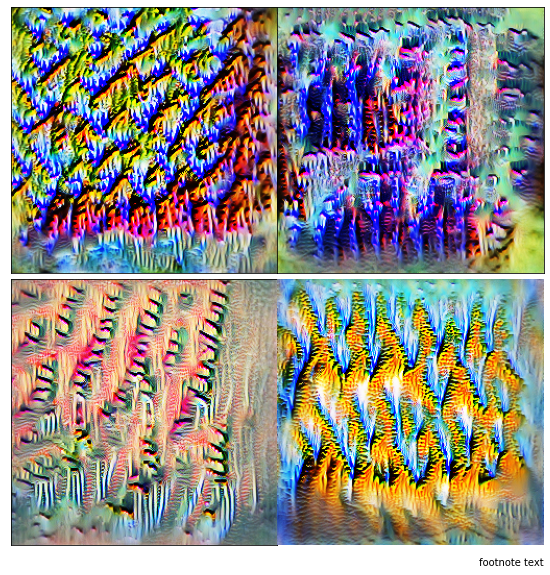

In [55]:
n_row = 2
n_col = 2
fig, axs = plt.subplots(n_row, n_col, figsize=(9.55, 10))
axs = axs.flatten()
for ix, ax in zip(range(n_row*n_col), axs):
    if ix > 3:
        continue
    img = render.render_vis(longcat, f"conv6:{ix}", param_f=lambda: param.image(256),
                            preprocess=True, progress=False, show_image=False)[0]
    img = np.reshape(img, (256, 256, 3))
    ax.imshow(img)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(x=0, y=0, tight=True)

plt.figtext(0.9, 0.1, 'footnote text', horizontalalignment='right')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.show()

In [22]:
!rm -rf frames/four_channels/test.png

In [14]:
!mkdir frames

In [15]:
!mkdir frames/four_channels

In [23]:
!ls frames/four_channels

In [68]:
!ffmpeg

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [69]:
!ffmpeg -framerate 30 -pattern_type glob -i 'frames/four_channels/*.png' \
  -c:v libx264 -pix_fmt yuv420p out.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [70]:
!ls

'11_Neuron diversity.ipynb'		 accuracies_kitty.pickle
 12_Feature_inversion.ipynb		 accuracies_longcat.pickle
 13_Activation_grid.ipynb		 captum
 14_Captum_attribution_methods.ipynb	 captum_old
 15_GradCAM_and_friends.ipynb		 captum_optim
 1_Match_tars_with_towns.ipynb		 cities.py
 2_Dataset_exploration.ipynb		 dataset
 3_Visualize_split.ipynb		 frames
 4_Kitty_training.ipynb			 map.png
 5_Longcat_training.ipynb		 nets.py
 6_Inception_training.ipynb		 out.mp4
 7_Visualize_kitty.ipynb		 prune_down.py
 8_Visualize_a_fresh_new_network.ipynb	 remove_pairless.py
 9_Visualize_Longcat.ipynb		 saved_models
 9_Visualize_inception.ipynb		 test.png
 Animation_playgroumd.ipynb		 train_test_split.py
 __pycache__				 unzip_and_prune.py
 accuracies_inception.pickle		 vis


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.load_state_dict(torch.load('saved_models/inception/epoch_7_batch_5000.pth', map_location=device))
model.to(device).eval()